In [69]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load the dataset

#read data from pickle
#2weeks
# full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/dataSingleOrbitMinute.pkl")
full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/dataSingleOrbitMinuteV2.pkl")
#3weeks
# full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/dataSingleOrbit3Weeks.pkl")
full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot", "xdotdot", "ydotdot", "zdotdot", "alt"]] = full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot", "xdotdot", "ydotdot", "zdotdot", "alt"]]/1000


# full_dataUnpickled['time_idx'] = range(1, len(full_dataUnpickled) + 1)
# full_dataUnpickled.sort_values(
# ["orbit_id", "time"],
# ascending=[True, True],
# inplace=True
# )
#remove orbit with orbit ids 120 and 136 (wrong orbit generated???)
# full_dataUnpickled = full_dataUnpickled[full_dataUnpickled["orbit_id"] != "120"]
# df = full_dataUnpickled[full_dataUnpickled["orbit_id"] != "136"]
# df = df[full_dataUnpickled["orbit_id"] == "1"]
#drop xdotdot, ydotdot, zdotdot, ecc, inc, alt
dfPhysicallyInformed = full_dataUnpickled.drop(columns=['ecc', 'inc', 'alt'])
#REMOVED TIME
dfDense = dfPhysicallyInformed.copy().drop(columns=['xdotdot', 'ydotdot', 'zdotdot'])


print(dfPhysicallyInformed.head())
print(dfDense.head())

   time            x           y            z      xdot      ydot      zdot  \
0     0  7304.355095    0.000000     0.000000 -0.000000  1.289166  7.311224   
1    60  7290.895157   77.302386   438.403129 -0.448521  1.286788  7.297713   
2   120  7250.566926  154.319781   875.186350 -0.895324  1.279670  7.257246   
3   180  7183.524795  230.768495  1308.736776 -1.338701  1.267839  7.189990   
4   240  7090.025181  306.367180  1737.454854 -1.776960  1.251345  7.096223   

    xdotdot       ydotdot       zdotdot  
0 -0.007480 -3.331074e-08 -8.902155e-08  
1 -0.007466 -7.919149e-05 -4.501297e-04  
2 -0.007423 -1.580213e-04 -8.983076e-04  
3 -0.007352 -2.362000e-04 -1.342779e-03  
4 -0.007252 -3.134092e-04 -1.781728e-03  
   time            x           y            z      xdot      ydot      zdot
0     0  7304.355095    0.000000     0.000000 -0.000000  1.289166  7.311224
1    60  7290.895157   77.302386   438.403129 -0.448521  1.286788  7.297713
2   120  7250.566926  154.319781   875.186350

In [2]:
#add gaussian noise to the data positions and velocities independently

# dataPos = df.iloc[:,0:3] + np.random.normal(0, 26, df.iloc[:,0:3].shape)
# dataVel = df.iloc[:,3:6] + np.random.normal(0, 0.07, df.iloc[:,3:6].shape)

# dataPos = df.iloc[:,0:3] + np.random.normal(0, 50, df.iloc[:,0:3].shape)
# dataVel = df.iloc[:,3:6] + np.random.normal(0, 0.1, df.iloc[:,3:6].shape)

# df = np.concatenate((dataPos, dataVel), axis=1) 
# df = pd.DataFrame(df, columns = ['x','y','z', 'xdot', 'ydot', 'zdot'])
# print(df.head())


In [70]:
print(dfPhysicallyInformed.shape)
print(dfDense.shape)


(20161, 10)
(20161, 7)


In [71]:
print(dfPhysicallyInformed.head())
print(dfDense.head())

   time            x           y            z      xdot      ydot      zdot  \
0     0  7304.355095    0.000000     0.000000 -0.000000  1.289166  7.311224   
1    60  7290.895157   77.302386   438.403129 -0.448521  1.286788  7.297713   
2   120  7250.566926  154.319781   875.186350 -0.895324  1.279670  7.257246   
3   180  7183.524795  230.768495  1308.736776 -1.338701  1.267839  7.189990   
4   240  7090.025181  306.367180  1737.454854 -1.776960  1.251345  7.096223   

    xdotdot       ydotdot       zdotdot  
0 -0.007480 -3.331074e-08 -8.902155e-08  
1 -0.007466 -7.919149e-05 -4.501297e-04  
2 -0.007423 -1.580213e-04 -8.983076e-04  
3 -0.007352 -2.362000e-04 -1.342779e-03  
4 -0.007252 -3.134092e-04 -1.781728e-03  
   time            x           y            z      xdot      ydot      zdot
0     0  7304.355095    0.000000     0.000000 -0.000000  1.289166  7.311224
1    60  7290.895157   77.302386   438.403129 -0.448521  1.286788  7.297713
2   120  7250.566926  154.319781   875.186350

# Prepare data for PINN

In [72]:
column_indices_PINN = {name: i for i, name in enumerate(dfPhysicallyInformed.columns)}

n = len(dfPhysicallyInformed)
train_df_PINN = dfPhysicallyInformed[0:int(n*0.6)]
val_df_PINN = dfPhysicallyInformed[int(n*0.6):int(n*0.8)]
test_df_PINN = dfPhysicallyInformed[int(n*0.8):]

num_features_PINN = dfPhysicallyInformed.shape[1]
print(num_features_PINN)

10


In [73]:
#standardize everything except time
train_mean_PINN = train_df_PINN.iloc[:, 1:].mean()
train_std_PINN = train_df_PINN.iloc[:, 1:].std()

train_df_PINN.iloc[:, 1:] = (train_df_PINN.iloc[:, 1:] - train_mean_PINN) / train_std_PINN
val_df_PINN.iloc[:, 1:] = (val_df_PINN.iloc[:, 1:] - train_mean_PINN) / train_std_PINN
test_df_PINN.iloc[:, 1:] = (test_df_PINN.iloc[:, 1:] - train_mean_PINN) / train_std_PINN

standardGravitationalParameter = ((3.986004418 * 10**(5) - train_mean_PINN) / train_std_PINN)[0]

C:\Users\jpfun\AppData\Local\Temp\ipykernel_83920\820124590.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_PINN.iloc[:, 1:] = (train_df_PINN.iloc[:, 1:] - train_mean_PINN) / train_std_PINN
C:\Users\jpfun\AppData\Local\Temp\ipykernel_83920\820124590.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df_PINN.iloc[:, 1:] = (val_df_PINN.iloc[:, 1:] - train_mean_PINN) / train_std_PINN
C:\Users\jpfun\AppData\Local\Temp\ipykernel_83920\820124590.py:7: SettingWithCopyWarning: 
A value is trying t

In [74]:
# print(train_df_PINN.head())
#destandardize first column of train_df_PINN
# train_df_PINN.iloc[:, 1] = train_df_PINN.iloc[:, 1] * train_std_PINN[0] + train_mean_PINN[0]

# print(train_df_PINN)
print(train_mean_PINN.head())

x      -92.016894
y       10.392004
z       23.300188
xdot    -0.004107
ydot     0.000602
dtype: float64


# Prepare data for Dense

In [75]:
column_indices_Dense = {name: i for i, name in enumerate(dfDense.columns)}

n = len(dfDense)
train_df_Dense = dfDense[0:int(n*0.6)]
val_df_Dense = dfDense[int(n*0.6):int(n*0.8)]
test_df_Dense = dfDense[int(n*0.8):]

num_features_Dense = dfDense.shape[1]
print(num_features_Dense)

7


In [76]:
#standardize everything
train_mean_Dense = train_df_Dense.mean()
train_std_Dense = train_df_Dense.std()

train_df_Dense = (train_df_Dense - train_mean_Dense) / train_std_Dense
val_df_Dense = (val_df_Dense - train_mean_Dense) / train_std_Dense
test_df_Dense = (test_df_Dense - train_mean_Dense) / train_std_Dense

In [8]:
# #drop columns
# test_df = test_df.drop(columns=['xdotdot', 'ydotdot', 'zdotdot', 'alt'])
# #create dummy test_df with sine wave with same length as test_df, for the six columns
# test_df[["x", "y", "z", "xdot", "ydot", "zdot"]] = full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot"]]/2000
# plt.plot(test_df["x"])
# print(test_df.shape)

In [77]:
#print shapes of train, test and validation sets
print(train_df_Dense.shape)
print(val_df_Dense.shape)
print(test_df_Dense.shape)


(12096, 7)
(4032, 7)
(4033, 7)


In [78]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


def plot(self, model=None, plot_col='x', max_subplots=1, isPinn=False):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  #destandardize data
  if isPinn:
    inputs = inputs * train_std_PINN[plot_col] + train_mean_PINN[plot_col]
    labels = labels * train_std_PINN[plot_col] + train_mean_PINN[plot_col]
  else:
    inputs = inputs * train_std_Dense[plot_col] + train_mean_Dense[plot_col]
    labels = labels * train_std_Dense[plot_col] + train_mean_Dense[plot_col]
  
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=12)
    if model is not None:
      if isPinn:
        #reshape inputs to be (xx, 1440, 7)
        inputs = tf.reshape(inputs, (inputs.shape[0], 1440, 7))
        print(inputs.shape)
        Trueictions = model(inputs)
      else:
        Trueictions = model(inputs)
      plt.scatter(self.label_indices, Trueictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Trueictions',
                  c='#ff7f0e', s=12)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [min]')
WindowGenerator.plot = plot


In [79]:
import torch
def split_window(self, features):
  inputs = features[:, self.input_slice, :].clone().detach()
  labels = features[:, self.labels_slice, :].clone().detach()
  
  if self.label_columns is not None:
      torch.stack(
        [labels[:, :, self.column_indices[name]].clone().detach() for name in self.label_columns],
        dim=-1)
  
  inputs = inputs.view([-1, self.input_width, inputs.shape[-1]])
  labels = labels.view([-1, self.label_width, labels.shape[-1]])
  
  return inputs, labels

WindowGenerator.split_window = split_window

In [80]:
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset

class TimeSeriesDataset(Dataset):
    def __init__(
        self,
        data,
        targets,
        sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        start_index=None,
        end_index=None,
    ):
        self.data = torch.tensor(data, dtype=torch.float32)
        if targets is not None:
            self.targets = torch.tensor(targets, dtype=torch.float32)
        else:
            self.targets = None
        self.sequence_length = sequence_length
        self.sequence_stride = sequence_stride
        self.sampling_rate = sampling_rate
        self.start_index = start_index
        self.end_index = end_index

    def __getitem__(self, index):
        data_sequence = self.data[index]
        if self.targets is not None:
            target_sequence = self.targets[index]
            return data_sequence, target_sequence
        else:
            return data_sequence

    def __len__(self):
        return len(self.data)

def timeseries_dataset_from_array(
    data,
    targets,
    sequence_length,
    sequence_stride=1,
    sampling_rate=1,
    batch_size=128,
    shuffle=False,
    seed=None,
    start_index=None,
    end_index=None,
):
    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)

    start_positions = torch.arange(start_index, end_index - sequence_length * sampling_rate + 1, sequence_stride)

    if shuffle:
        if seed is not None:
            torch.manual_seed(seed)
        start_positions = start_positions[torch.randperm(len(start_positions))]

    indices = []
    for position in start_positions:
        sequence_indices = torch.arange(position, position + sequence_length * sampling_rate, sampling_rate)
        indices.append(sequence_indices)
    indices = torch.stack(indices)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        target_ds = sequences_from_indices(targets, start_positions, start_index, end_index)
        dataset = torch.utils.data.TensorDataset(dataset, target_ds)
    if batch_size is not None:
        dataset = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        dataset = DataLoader(dataset, shuffle=shuffle)

    return dataset

def sequences_from_indices(array, indices, start_index, end_index):
    sequences = []
    for indices_sequence in indices:
        sequence = torch.tensor(array[indices_sequence], dtype=torch.float32)
        sequences.append(sequence)
    sequences = torch.stack(sequences)
    sequences = sequences[start_index:end_index]

    return sequences

In [81]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    dataloader = timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        batch_size=32,
        shuffle=False,
    )
    dataloader = map(self.split_window, dataloader)
    return dataloader

WindowGenerator.make_dataset = make_dataset

In [82]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [83]:
#minutes in two days = 2880
#minutes in a day = 1440

#prev = 1000
INPUT_STEPS = 300
OUT_STEPS = 30
multi_window_PINN = WindowGenerator(input_width=INPUT_STEPS,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               label_columns=['time', 'x', 'y', 'z', 'xdot', 'ydot', 'zdot', 'xdotdot', 'ydotdot', 'zdotdot'],
                               train_df=train_df_PINN,
                               val_df=val_df_PINN,
                               test_df=test_df_PINN)

multi_window_Dense = WindowGenerator(input_width=INPUT_STEPS,
                                label_width=OUT_STEPS,
                                shift=OUT_STEPS,
                                label_columns=['time', 'x', 'y', 'z', 'xdot', 'ydot', 'zdot'],
                                train_df=train_df_Dense,
                                val_df=val_df_Dense,
                                test_df=test_df_Dense)

multi_val_performance_PINN = {}
multi_performance_PINN = {}

multi_val_performance_Dense = {}
multi_performance_Dense = {}


In [785]:
example_inputs_PINN, example_labels_PINN = next(iter(multi_window_PINN.train))
print(f'Inputs shape (batch, time, features): {example_inputs_PINN.shape}')
print(f'Labels shape (batch, time, features): {example_labels_PINN.shape}')

# #print all of the data inside multi_window.train
# for example_inputs_PINN, example_labels_PINN in multi_window_PINN.train:
#  print(f'Inputs shape (batch, time, features): {example_inputs_PINN.shape}')
#  print(f'Labels shape (batch, time, features): {example_labels_PINN.shape}')


Inputs shape (batch, time, features): torch.Size([32, 1000, 10])
Labels shape (batch, time, features): torch.Size([32, 30, 10])


In [84]:
example_inputs_Dense, example_labels_Dense = next(iter(multi_window_Dense.train))
print(f'Inputs shape (batch, time, features): {example_inputs_Dense.shape}')
print(f'Labels shape (batch, time, features): {example_labels_Dense.shape}')

Inputs shape (batch, time, features): torch.Size([32, 300, 7])
Labels shape (batch, time, features): torch.Size([32, 30, 7])


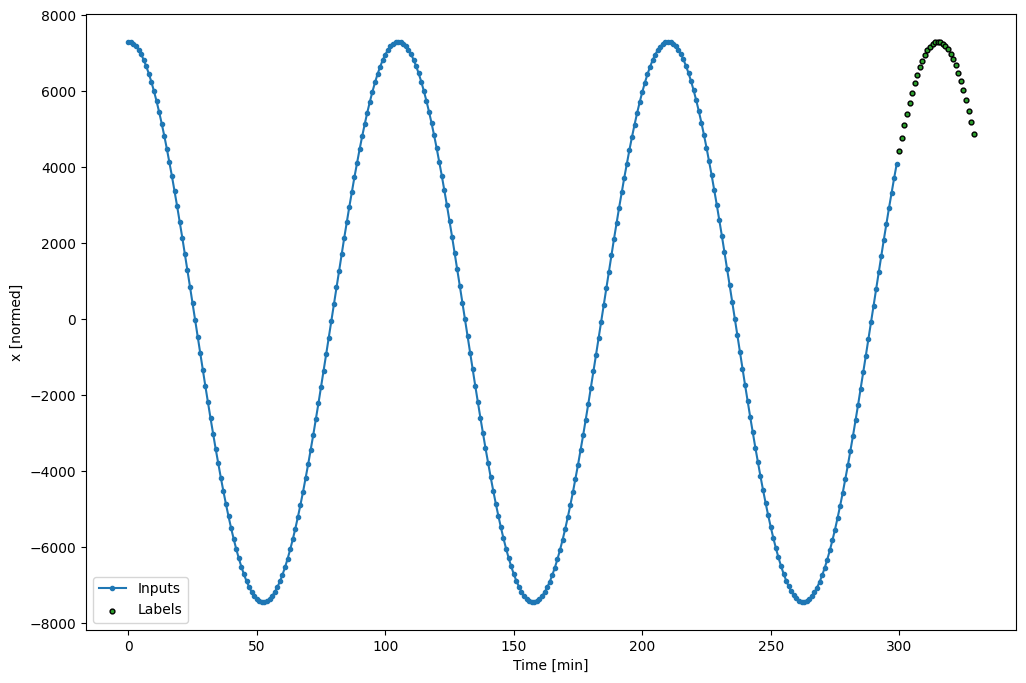

In [85]:
multi_window_PINN.plot(max_subplots=1, plot_col='x')
# multi_window

# Dense Pytorch

In [588]:
import torch
import torch.nn as nn
import torch.optim as optim

MAX_EPOCHS = 2

class MultiLinearModelDense(nn.Module):
    def __init__(self, input_steps, out_steps, num_features):

        class LambdaLayer(nn.Module):
            def __init__(self, lambda_fn):
                super(LambdaLayer, self).__init__()
                self.lambda_fn = lambda_fn

            def forward(self, x):
                return self.lambda_fn(x)
            
            
        super(MultiLinearModelDense, self).__init__()
        self.input_steps = input_steps
        self.out_steps = out_steps
        self.num_features = num_features
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_steps * num_features, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 16)
        self.fc4 = nn.Linear(16, out_steps * num_features)
        self.reshape = LambdaLayer(lambda x: x.view(-1, OUT_STEPS, num_features_Dense))
        
    def forward(self, x):
        x = x[:, -self.input_steps:, :]
 
        batch_size_value = x.size(0)
        x = x.view(batch_size_value, -1) 
        x = nn.ReLU()(self.fc1(x))
        x = nn.ReLU()(self.fc2(x))
        x = nn.ReLU()(self.fc3(x))
        x = self.fc4(x)
        x = self.reshape(x)
        return x

    def predict(model, inputs):
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            inputs = torch.tensor(inputs)  # Convert inputs to a tensor
            inputs = inputs.float()  # Convert the tensor to float data type

            predictions = model(inputs)  # Forward pass

        return predictions.numpy()  # Convert predictions to a NumPy array

def compile_and_fit(model, window, epochs=MAX_EPOCHS, patience=15):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    early_stopping = False
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, targets in window.train:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        window_train = list(window.train)
        train_loss /= len(window_train)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            val_data = list(window.val)  # Convert window.val to a list
            for inputs, targets in val_data:
                outputs = model(inputs)
                val_loss += criterion(outputs, targets).item()
            val_loss /= len(val_data)  # Calculate the average validation loss
        
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stopping = True
                break
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    return early_stopping

    

input_steps = INPUT_STEPS  # Replace INPUT_STEPS with the appropriate value
out_steps = OUT_STEPS  # Replace OUT_STEPS with the appropriate value
num_features = num_features_Dense  # Replace num_features_Dense with the appropriate value

model = MultiLinearModelDense(input_steps, out_steps, num_features)
dataset = multi_window_Dense  # Replace multi_window_Dense with the appropriate dataset

early_stopping = compile_and_fit(model, dataset, epochs=100)

Epoch 1/100, Training Loss: 0.9529, Validation Loss: 1.0045
Epoch 2/100, Training Loss: 0.6580, Validation Loss: 0.5810
Epoch 3/100, Training Loss: 0.3237, Validation Loss: 0.2672
Epoch 4/100, Training Loss: 0.1356, Validation Loss: 0.1299
Epoch 5/100, Training Loss: 0.0585, Validation Loss: 0.0747
Epoch 6/100, Training Loss: 0.0295, Validation Loss: 0.0530
Epoch 7/100, Training Loss: 0.0189, Validation Loss: 0.0437
Epoch 8/100, Training Loss: 0.0149, Validation Loss: 0.0392
Epoch 9/100, Training Loss: 0.0129, Validation Loss: 0.0362
Epoch 10/100, Training Loss: 0.0118, Validation Loss: 0.0342
Epoch 11/100, Training Loss: 0.0112, Validation Loss: 0.0330
Epoch 12/100, Training Loss: 0.0108, Validation Loss: 0.0318
Epoch 13/100, Training Loss: 0.0106, Validation Loss: 0.0313
Epoch 14/100, Training Loss: 0.0106, Validation Loss: 0.0311
Epoch 15/100, Training Loss: 0.0105, Validation Loss: 0.0308
Epoch 16/100, Training Loss: 0.0105, Validation Loss: 0.0307
Epoch 17/100, Training Loss: 0.01

C:\Users\jpfun\AppData\Local\Temp\ipykernel_61716\1644169549.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs)  # Convert inputs to a tensor


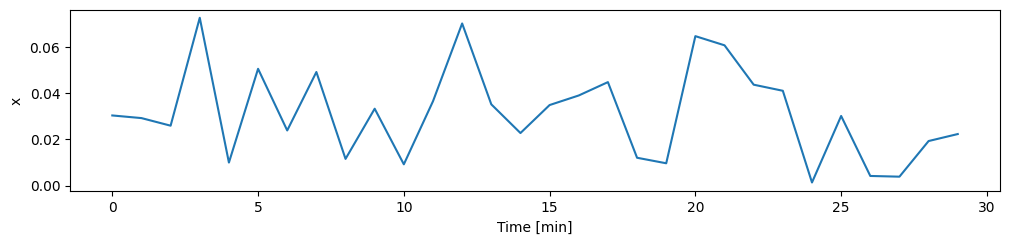

0


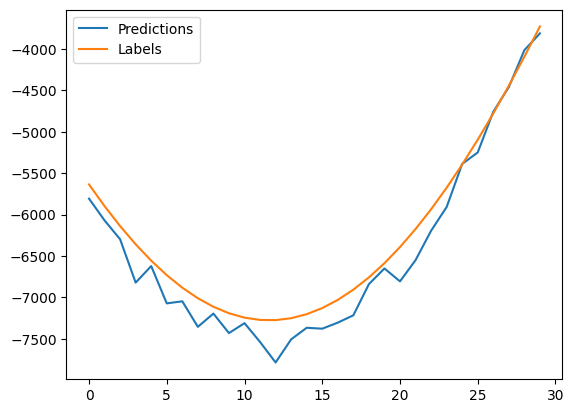

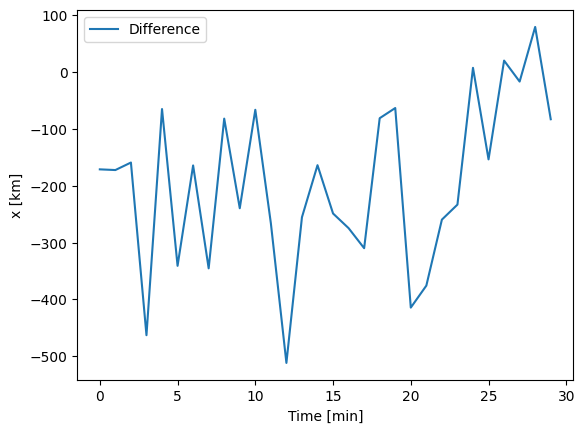

Mean Errors:
X:  467.7933
Y:  48.105957
Z:  493.53033
XDOT:  0.3996074
YDOT:  0.041852627
ZDOT:  0.41313082


In [589]:


def plot_diff_Dense(model, window, max_subplots=1, column=0):
    
    inputs, labels = next(iter(window.test))
    predictions = model.predict(inputs)
    
    
    inputs = inputs.numpy()
    labels = labels.numpy()

    
    inputs = inputs * train_std_Dense[column] + train_mean_Dense[column]
    labels = labels * train_std_Dense[column] + train_mean_Dense[column]
    predictions = predictions * train_std_Dense[column] + train_mean_Dense[column]
    
    plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel('x')
        plt.plot(np.abs((predictions[n, :, column] - labels[n, :, column]) / labels[n, :, column]), label='Relative Error')
        plt.xlabel('Time [min]')
        plt.show()

        print(n)
        plt.plot(predictions[n, :, column], label='Predictions')
        plt.plot(labels[n, :, column], label='Labels')
        plt.legend()
        plt.show()

        plt.ylabel('x [km]')
        plt.plot((predictions[n, :, column] - labels[n, :, column]), label='Difference')
        plt.xlabel('Time [min]')
        plt.legend()
        plt.show()


plot_diff_Dense(model, multi_window_Dense, column=0)

# Calculate the mean absolute error for each column
def calculateMeanErrors(model, window, max_subplots=1, column=0):
    
    inputs, labels = next(iter(window.test))
    predictions = model.predict(inputs)
    
    
    inputs = inputs.numpy()
    labels = labels.numpy()
    
    inputs = inputs * train_std_Dense[column] + train_mean_Dense[column]
    labels = labels * train_std_Dense[column] + train_mean_Dense[column]
    predictions = predictions * train_std_Dense[column] + train_mean_Dense[column]
    
    meanError = np.mean(np.abs(predictions[:, :, column] - labels[:, :, column]))
    return meanError

meanErrorX = calculateMeanErrors(model, multi_window_Dense, column=0)
meanErrorY = calculateMeanErrors(model, multi_window_Dense, column=1)
meanErrorZ = calculateMeanErrors(model, multi_window_Dense, column=2)
meanErrorXDOT = calculateMeanErrors(model, multi_window_Dense, column=3)
meanErrorYDOT = calculateMeanErrors(model, multi_window_Dense, column=4)
meanErrorZDOT = calculateMeanErrors(model, multi_window_Dense, column=5)

print("Mean Errors:")
print("X: ", meanErrorX)
print("Y: ", meanErrorY)
print("Z: ", meanErrorZ)
print("XDOT: ", meanErrorXDOT)
print("YDOT: ", meanErrorYDOT)
print("ZDOT: ", meanErrorZDOT)

# PINN (without initial state)

In [590]:
def set_device(cuda: bool):
    # if torch.cuda.is_available():
    #     device = torch.device("cuda")
    #     torch.set_default_tensor_type('torch.cuda.FloatTensor')
    # else:
    device = torch.device("cuda" if (torch.cuda.is_available() and cuda) else "cpu")
    torch.set_default_tensor_type('torch.FloatTensor')
    if device.type == "cuda":
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    return device

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

class PhysicsInformedNN_noInitialState():
    def __init__(self, windowData, windowDataValidation, device: torch.device = ("cpu")):
        # data
        self.windowData = windowData
        self.windowDataValidation = windowDataValidation
        
        self.allLossesTraining = []
        self.allLossesValidation = []

        self.u_net_LossesTraining = []
        self.u_net_LossesValidation = []

        self.f_net_LossesTraining = []
        self.f_net_LossesValidation = []
        

        class LambdaLayer(nn.Module):
            def __init__(self, lambda_fn):
                super(LambdaLayer, self).__init__()
                self.lambda_fn = lambda_fn

            def forward(self, x):
                return self.lambda_fn(x)
            
        # deep neural networks
        self.dnn = nn.Sequential(
            nn.Flatten(),
            # nn.LeakyReLU(),
            #32 = batch size
            nn.Linear(INPUT_STEPS, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 16),
            nn.Linear(16, OUT_STEPS*(num_features_PINN-1), bias=False),
            LambdaLayer(lambda x: x.view(-1, OUT_STEPS, num_features_PINN-1))
        )

        # optimizers: using the same settings
        self.optimizer = optim.Adam(self.dnn.parameters())
        
        self.iter = 0
        
    def net_u(self, time):  
        #remove the time
        # # windowData = windowData[:, :, :-1]
        # time = windowData[:, :, 0:1]
        # initial_state = windowData[:, :, 1:]
        #tf.concat([time, initial_state], axis=-1)
        #32 = batch size, 1 = feature (time)
        
        u = self.dnn(time)
        # u = self.dnn(windowData)
        return u
    
    def net_f(self, time, data):

        x = data[:, :, 0]
        y = data[:, :, 1]
        z = data[:, :, 2]
        xdot = data[:, :, 3]
        ydot = data[:, :, 4]
        zdot = data[:, :, 5]
        xdotdot = data[:, :, 6]
        ydotdot = data[:, :, 7]
        zdotdot = data[:, :, 8]


        x_dot = torch.autograd.grad(x, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(x))[0][:, :OUT_STEPS]
        y_dot = torch.autograd.grad(y, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(y))[0][:, :OUT_STEPS]
        z_dot = torch.autograd.grad(z, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(z))[0][:, :OUT_STEPS]
        x_dot_dot = torch.autograd.grad(x_dot, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(x_dot))[0][:, :OUT_STEPS]
        y_dot_dot = torch.autograd.grad(y_dot, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(y_dot))[0][:, :OUT_STEPS]
        z_dot_dot = torch.autograd.grad(z_dot, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(z_dot))[0][:, :OUT_STEPS]

        
        #call SINDy to get the equations
        # model = getSindyEquations(data[:, :, 1:], data[:, :, 0])

        #create a tuple with the residual for each axis
        res_px = x_dot - xdot
        res_py = y_dot - ydot
        res_pz = z_dot - zdot
        # standardGravitationalParameter = 3.986004418 * 10**(5), using standardized  
        r = torch.sqrt(x**2 + y**2 + z**2)
        res_vx = x_dot_dot + standardGravitationalParameter * x/(r**3) 
        res_vy = y_dot_dot + standardGravitationalParameter * y/(r**3) 
        res_vz = z_dot_dot + standardGravitationalParameter * z/(r**3) 

        res_accX = x_dot_dot - xdotdot
        res_accY = y_dot_dot - ydotdot
        res_accZ = z_dot_dot - zdotdot


        #concatenate the residuals into a single tensor
        res = torch.stack([res_px, res_py, res_pz, res_vx, res_vy, res_vz, res_accX, res_accY, res_accZ], dim=1)

        return res
    
    def loss_func(self, isTraining=True):
        
        if isTraining:
            self.dnn.train()
            # self.optimizer.zero_grad()
            windowData = self.windowData
        else:
            self.dnn.eval()
            windowData = self.windowDataValidation


        for inputs, labels in windowData:
            # print(inputs.shape)
            #separate the time from the rest of the data
            timeAux = inputs[:, :, 0].clone().detach().requires_grad_(True)

            # initial_state = inputs[:, 0, 1:]
            # inputs = inputs[:, :, 1:]
            # u_pred = self.net_u(timeAux)
            self.optimizer.zero_grad()
            # u_pred = self.net_u(timeAux)
            u_pred = self.net_u(timeAux)

            
            #limit timeAux for each batch to the shape of the output of the neural network
            # mask = torch.zeros_like(timeAux)
            # mask[:, :labels.shape[1]] = 1.0
            # timeAuxSliced = torch.where(mask.bool(), timeAux, torch.zeros_like(timeAux))
            # timeAux.retain_grad()

            f_pred = self.net_f(timeAux, u_pred)

            #remove the time from the labels
            labels = labels[:, :, 1:].clone().detach()
            loss_u = torch.mean(torch.square(labels - u_pred))
            loss_f = torch.mean(torch.square(f_pred))
            loss = loss_u + loss_f
            loss.backward()
            self.optimizer.step()

            self.iter += 1


            if self.iter % 100 == 0:
                print(
                    # 'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.detach().numpy(), loss_u.detach().numpy(), loss_f.detach().numpy())
                    'Iter %d, Loss: %.5e, Loss_u: %.5e' % (self.iter, loss.detach().numpy(), loss_u.detach().numpy())
                )
                
        return loss.detach().numpy(), loss_u.detach().numpy(), #loss_f.detach().numpy()

    def validate(self):
        loss_Aux = np.array([])
        lossU_Aux = np.array([])
        #lossF_Aux = np.array([])

        # loss, lossU, lossF = self.loss_func(isTraining=False)
        loss, lossU = self.loss_func(isTraining=False)

        loss_Aux = np.append(loss_Aux, loss)
        lossU_Aux = np.append(lossU_Aux, lossU)
        # lossF_Aux = np.append(lossF_Aux, lossF)
        
        self.allLossesValidation.append(np.mean(loss_Aux))
        self.u_net_LossesValidation.append(np.mean(lossU_Aux))
        # self.f_net_LossesValidation.append(np.mean(lossF_Aux))
    

    

    def train(self):
        epochs = 100
        for epoch in range(epochs):
            print('EPOCH %d' % (epoch))
            loss_Aux = np.array([])
            lossU_Aux = np.array([])
            # lossF_Aux = np.array([])

            # print(example_inputs.shape) doesnt print anything after the first epoch why?
            # print(example_labels.shape)
            

            # loss, lossU, lossF = self.loss_func()
            loss, lossU = self.loss_func()

            loss_Aux = np.append(loss_Aux, loss)
            lossU_Aux = np.append(lossU_Aux, lossU)
            # lossF_Aux = np.append(lossF_Aux, lossF)
            
            self.allLossesTraining.append(np.mean(loss_Aux))
            self.u_net_LossesTraining.append(np.mean(lossU_Aux))
            # self.f_net_LossesTraining.append(np.mean(lossF_Aux))

            self.validate()

        self.dnn.eval()
        

    def predict(self, X):
        self.dnn.eval()
        outputsU = []
        # outputsF = []
        for inputs, labels in X:
            #separate the time from the rest of the data
            # timeAux = inputs[:, :, 0].clone().detach()
            # u = self.net_u(timeAux)
            u = self.net_u(inputs)

            # time = timeAux[:, 0:OUT_STEPS].clone().detach()
            # f = self.net_f(time, u)
            outputsU.append(u.detach().numpy())
            # outputsF.append(f.detach().numpy())

        # return np.concatenate(outputsU, axis=0), np.concatenate(outputsF, axis=0)
        return np.concatenate(outputsU, axis=0)

    def plot_losses(self, graphics = "allLosses"):
        
        # allLossesTraining
        # u_net_LossesTraining
        # f_net_LossesTraining

        # allLossesValidation
        # u_net_LossesValidation
        # f_net_LossesValidation

        if graphics == "f_losses":
            plt.plot(self.f_net_LossesTraining, label='Training Loss')
            plt.plot(self.f_net_LossesValidation, label='Validation Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training and Validation Physical Loss')
            plt.legend()
            plt.show()
        elif graphics == "u_losses":
            plt.plot(self.u_net_LossesTraining, label='Training Loss')
            plt.plot(self.u_net_LossesValidation, label='Validation Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training and Validation Data Loss')
            plt.legend()
            plt.show()
        else:
            plt.plot(self.allLossesTraining, label='Training Loss')
            plt.plot(self.allLossesValidation, label='Validation Loss')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.title('Training and Validation Total Loss')
            plt.legend()
            plt.show()

device = set_device(cuda = False)

modelTest_noInitialState = PhysicsInformedNN_noInitialState(multi_window_PINN.train, multi_window_PINN.val)
modelTest_noInitialState.train()

NameError: name 'set_device' is not defined

C:\Users\jpfun\AppData\Local\Temp\ipykernel_61716\2210173890.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features[:, self.input_slice, :]).clone().detach()
C:\Users\jpfun\AppData\Local\Temp\ipykernel_61716\2210173890.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(features[:, self.labels_slice, :]).clone().detach()


(3704, 30, 9)


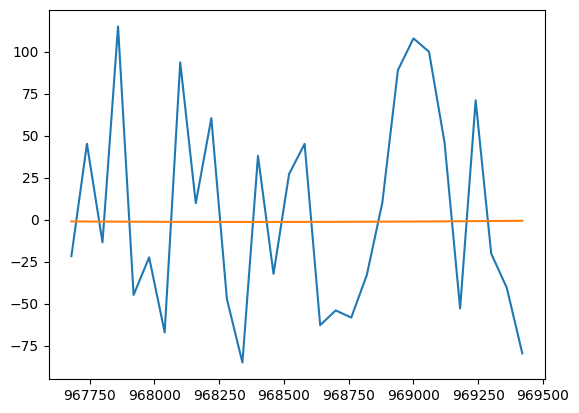

In [369]:
#predict the results

#(32, 1440, 1)

time_valuesAUX = torch.cat([time for (time, _) in multi_window_PINN.test], dim=0)
time_valuesAUX = time_valuesAUX[:, :, 0].unsqueeze(-1)
# remove the last dimension from time_tensor
time_valuesAUX = time_valuesAUX.squeeze(-1)


# time_values = tf.concat([window[:, :, 0] for window, _ in multi_window_PINN.test], axis=0)
# time_values = tf.expand_dims(time_values, axis=-1)

# u_pred, f_pred = modelTest_noInitialState.predict(time_values)
u_pred = modelTest_noInitialState.predict(multi_window_PINN.test)
u_pred = np.array(u_pred)
#print
print(u_pred.shape)

#reshape the results (xxx, OutputSteps, Variables)
u_pred_reshaped = torch.reshape(torch.from_numpy(u_pred), (u_pred.shape[0], OUT_STEPS, 9))

#extract the time from the test data
# timesAux = multi_window_PINN.test.map(lambda x, y: (x[:, :, 0], y))
# timesAux = tf.concat([x for (x, _) in timesAux], axis=0)
# print(timesAux)

#extract the time from the test data
# time_values = tf.concat([window[:, :, 0] for window, _ in multi_window_PINN.test], axis=0)
# print(time_values)
# print(time_values.shape)

#iterate over the predictions to discard the last value (only batchsize 2)
# u_predAux = []
# for i in range(len(u_pred)):
#     if i == len(u_pred)-1:
#         break
#     else:
#         u_predAux.append(u_pred[i])

# u_pred = np.array(u_predAux)
# # print(u_pred.shape)


# f_predAux = []
# for i in range(len(f_pred)):
#     if i == len(f_pred)-1:
#         break
#     else:
#         f_predAux.append(f_pred[i])

# f_pred = np.array(f_predAux)
# # print(f_pred.shape)


#plot the results
#1st dimension, number of windows
#2nd dimension, number of out timesteps
#3rd dimension, number of variables
# print(time_values[0,:][:OUT_STEPS,:])
windowNr = 0
plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], u_pred_reshaped[windowNr, :,  0], label='x')


# plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], f_pred_reshaped[windowNr, :,  4], label='xdot')
# plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], u_pred_reshaped[windowNr, :,  4], label='xdot')

#adicionar os valores reais
realVals = tf.concat([labels for (inputs, labels) in multi_window_PINN.test], axis=0)
realValsX = tf.expand_dims(realVals[:, :, 1], axis=-1)
realValsX = tf.squeeze(realValsX, axis=-1)
realValsY = tf.expand_dims(realVals[:, :, 2], axis=-1)
realValsY = tf.squeeze(realValsY, axis=-1)
realValsZ = tf.expand_dims(realVals[:, :, 3], axis=-1)
realValsZ = tf.squeeze(realValsZ, axis=-1)
realValsXDOT = tf.expand_dims(realVals[:, :, 4], axis=-1)
realValsXDOT = tf.squeeze(realValsXDOT, axis=-1)
realValsYDOT = tf.expand_dims(realVals[:, :, 5], axis=-1)
realValsYDOT = tf.squeeze(realValsYDOT, axis=-1)
realValsZDOT = tf.expand_dims(realVals[:, :, 6], axis=-1)
realValsZDOT = tf.squeeze(realValsZDOT, axis=-1)

plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], realValsX[windowNr,:][:OUT_STEPS], label='x')
# plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], realValsY[windowNr,:][:OUT_STEPS], label='y')
# plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], realValsZ[windowNr,:][:OUT_STEPS], label='z')
# plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], realValsXDOT[windowNr,:][:OUT_STEPS], label='xdot')
# plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], realValsYDOT[windowNr,:][:OUT_STEPS], label='ydot')
# plt.plot(time_valuesAUX[windowNr,:][:OUT_STEPS], realValsZDOT[windowNr,:][:OUT_STEPS], label='zdot')

# plotAUX(multi_window_PINN, model=modelTest_noInitialState, max_subplots=3, column=1)
# multi_window_PINN.plot(modelTest_noInitialState.dnn, isPinn=True)


C:\Users\jpfun\AppData\Local\Temp\ipykernel_61716\2210173890.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(features[:, self.input_slice, :]).clone().detach()
C:\Users\jpfun\AppData\Local\Temp\ipykernel_61716\2210173890.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(features[:, self.labels_slice, :]).clone().detach()


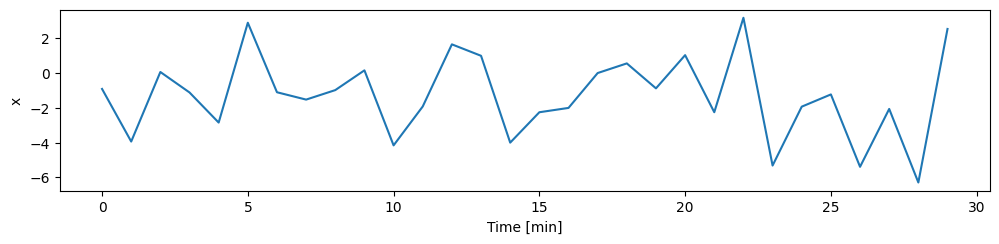

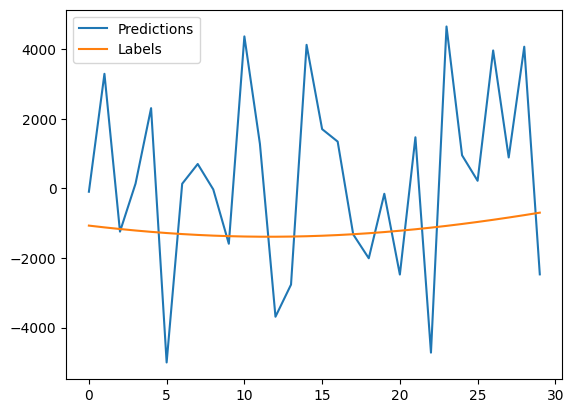

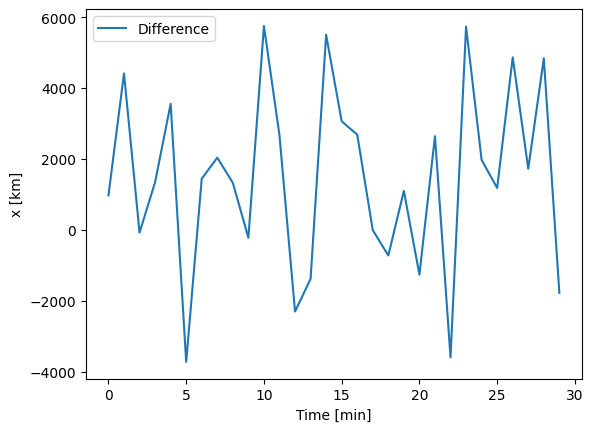

Mean Errors: 
X:  2463.3872
Y:  10010.858
Z:  3.8164685
XDOT:  0.78908753
YDOT:  6.011539
ZDOT:  0.0060769618


In [359]:
import IPython
import IPython.display

#plot the difference between the real and the predicted values with the column as a parameter
def plot_diff_PINN(model, window, max_subplots=1, column=0):
    #bcs first column is time
    column += 1
    
    inputs, labels = next(iter(window.test))
    
    # inputs = inputs.numpy()
    # labels = labels.numpy()
    predictions = model.predict(window.test)
    # predictions = predictions.numpy()

    inputs = inputs * train_std_PINN[column] + train_mean_PINN[column]
    labels = labels * train_std_PINN[column] + train_mean_PINN[column]
    predictions  = predictions * train_std_PINN[column] + train_mean_PINN[column]
    
    #make labels numpy
    labels = labels.numpy()

    plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)

        #fazer legendas diferentes para as velocidades
        plt.ylabel('x')
        plt.plot((predictions[n, :, column] - labels[n, :, column])/labels[n, :, column] ,label='Relative Error')
        plt.xlabel('Time [min]')
        plt.show()
        plt.plot(predictions[n, :, column] ,label='Predictions')
        plt.plot(labels[n, :, column] ,label='Labels')
        plt.legend()
        plt.show()

        plt.ylabel('x [km]')
        plt.plot((predictions[n, :, column] - labels[n, :, column]) ,label='Difference')
        plt.xlabel('Time [min]')
        plt.legend()
        plt.show()

        
plot_diff_PINN(modelTest_noInitialState, multi_window_PINN, column=0)

#calculate the mean absolute error for each column
def calculateMeanErrors(model, window, max_subplots=1, column=0):
    #bcs first column is time
    column += 1

    inputs, labels = next(iter(window.test))
    predictions = model.predict(window.test)
    
    inputs = inputs * train_std_PINN[column] + train_mean_PINN[column]
    labels = labels * train_std_PINN[column] + train_mean_PINN[column]
    predictions  = predictions * train_std_PINN[column] + train_mean_PINN[column]
    
    labels = labels.numpy()
    
    meanError = np.mean(np.abs(predictions[0, :, column] - labels[0, :, column]))
    return meanError
    
    
meanErrorX = calculateMeanErrors(modelTest_noInitialState, multi_window_PINN, column=0)
meanErrorY = calculateMeanErrors(modelTest_noInitialState, multi_window_PINN, column=1)
meanErrorZ = calculateMeanErrors(modelTest_noInitialState, multi_window_PINN, column=2)
meanErrorXDOT = calculateMeanErrors(modelTest_noInitialState, multi_window_PINN, column=3)
meanErrorYDOT = calculateMeanErrors(modelTest_noInitialState, multi_window_PINN, column=4)
meanErrorZDOT = calculateMeanErrors(modelTest_noInitialState, multi_window_PINN, column=5)

print("Mean Errors: ")
print("X: ", meanErrorX)
print("Y: ", meanErrorY)
print("Z: ", meanErrorZ)
print("XDOT: ", meanErrorXDOT)
print("YDOT: ", meanErrorYDOT)
print("ZDOT: ", meanErrorZDOT)




# PINN without inital state (working?)

Epoch 1/200, Training Loss: 1369.4238, Training Loss_u: 1.0446, Training Loss_f: 1368.3792, Validation Loss: 1.3056
Epoch 2/200, Training Loss: 487.5810, Training Loss_u: 1.0705, Training Loss_f: 486.5105, Validation Loss: 1.3030
Epoch 3/200, Training Loss: 155.6510, Training Loss_u: 1.0922, Training Loss_f: 154.5588, Validation Loss: 1.3232
Epoch 4/200, Training Loss: 67.1188, Training Loss_u: 1.1075, Training Loss_f: 66.0112, Validation Loss: 1.3362
Epoch 5/200, Training Loss: 40.8646, Training Loss_u: 1.1167, Training Loss_f: 39.7478, Validation Loss: 1.3458
Epoch 6/200, Training Loss: 29.2474, Training Loss_u: 1.1233, Training Loss_f: 28.1241, Validation Loss: 1.3534
Epoch 7/200, Training Loss: 22.4104, Training Loss_u: 1.1286, Training Loss_f: 21.2818, Validation Loss: 1.3599
Epoch 8/200, Training Loss: 17.8196, Training Loss_u: 1.1332, Training Loss_f: 16.6865, Validation Loss: 1.3655
Epoch 9/200, Training Loss: 14.5139, Training Loss_u: 1.1373, Training Loss_f: 13.3766, Validati

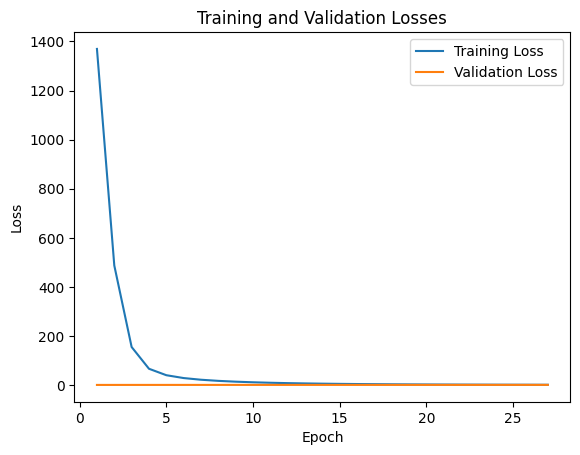

In [110]:
#Trying to use dense backbone for PINN
import torch
import torch.nn as nn
import torch.optim as optim


class MultiLinearModelPINN(nn.Module):
    def __init__(self, input_steps, out_steps, num_features):
        
        self.allLossesTraining = []
        self.allLossesValidation = []

        self.u_net_LossesTraining = []
        self.u_net_LossesValidation = []

        self.f_net_LossesTraining = []
        self.f_net_LossesValidation = []


        class LambdaLayer(nn.Module):
            def __init__(self, lambda_fn):
                super(LambdaLayer, self).__init__()
                self.lambda_fn = lambda_fn

            def forward(self, x):
                return self.lambda_fn(x)
            
            
        super(MultiLinearModelPINN, self).__init__()
        self.input_steps = input_steps
        self.out_steps = out_steps
        self.num_features = num_features
        


        self.dnn = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_steps*num_features, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 16),
            nn.Linear(16, out_steps * (num_features - 1), bias=False),
            LambdaLayer(lambda x: x.view(-1, out_steps, num_features - 1))
        )
        
    def forward(self, x):
        return self.dnn(x)

    def predict(model, data):
        model.eval()  # Set the model to evaluation mode
        outputsU = []
        # outputsF = []
        for inputs, labels in data:
            #separate the time from the rest of the data
            # timeAux = inputs[:, :, 0].clone().detach()
            # u = model(timeAux)
            u = model(inputs)
            # time = timeAux[:, 0:OUT_STEPS].clone().detach()
            # f = self.net_f(time, u)
            outputsU.append(u.detach().numpy())
            # outputsF.append(f.detach().numpy())

        # return np.concatenate(outputsU, axis=0), np.concatenate(outputsF, axis=0)
        return np.concatenate(outputsU, axis=0)


def plot_losses(train_losses, val_losses):
    epochs = len(train_losses)
    x = range(1, epochs+1)

    plt.plot(x, train_losses, label='Training Loss')
    plt.plot(x, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()


def compile_and_fit(model, window, epochs, out_steps, num_features, patience=25):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00001)
    # optimizer = optim.LBFGS(model.parameters(), lr=0.001)
    
    early_stopping = False
    best_loss = float('inf')
    patience_counter = 0

    losses_Train = []
    losses_u_Train = []
    losses_f_Train = []

    losses_Val = []
    losses_u_Val = []
    losses_f_Val = []
    
    def model_f(time, data):
        
        # print(data.shape)
        # time = time[:, :, 0].clone().detach().requires_grad_(True)
        # #add extra dimension to time
        # time = time.unsqueeze(2).retain_grad()
        # print(time.shape)
        # print(data)
        # print(time)

        x = data[:, :, 0]
        y = data[:, :, 1]
        z = data[:, :, 2]
        xdot = data[:, :, 3]
        ydot = data[:, :, 4]
        zdot = data[:, :, 5]
        # xdotdot = data[:, :, 6]
        # ydotdot = data[:, :, 7]
        # zdotdot = data[:, :, 8]


        x_dot = torch.autograd.grad(x, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(x))[0][:, :OUT_STEPS]
        #select the first two dimensions of the tensor so that the shape is 32,30
        x_dot = x_dot[:, :, 0].unsqueeze(-1).squeeze()

        y_dot = torch.autograd.grad(y, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(y))[0][:, :OUT_STEPS]
        y_dot = y_dot[:, :, 0].unsqueeze(-1).squeeze()

        z_dot = torch.autograd.grad(z, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(z))[0][:, :OUT_STEPS]
        z_dot = z_dot[:, :, 0].unsqueeze(-1).squeeze()

        x_dot_dot = torch.autograd.grad(x_dot, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(x_dot))[0][:, :OUT_STEPS]
        x_dot_dot = x_dot_dot[:, :, 0].unsqueeze(-1).squeeze()

        y_dot_dot = torch.autograd.grad(y_dot, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(y_dot))[0][:, :OUT_STEPS]
        y_dot_dot = y_dot_dot[:, :, 0].unsqueeze(-1).squeeze()

        z_dot_dot = torch.autograd.grad(z_dot, time, create_graph=True, retain_graph=True, grad_outputs=torch.ones_like(z_dot))[0][:, :OUT_STEPS]
        z_dot_dot = z_dot_dot[:, :, 0].unsqueeze(-1).squeeze()

        
        #call SINDy to get the equations
        # model = getSindyEquations(data[:, :, 1:], data[:, :, 0])

        #create a tuple with the residual for each axis
        res_px = x_dot - xdot
        res_py = y_dot - ydot
        res_pz = z_dot - zdot
        # standardGravitationalParameter = 3.986004418 * 10**(5), using standardized  
        r = torch.sqrt(x**2 + y**2 + z**2)
        res_vx = x_dot_dot + standardGravitationalParameter * x/(r**3) 
        res_vy = y_dot_dot + standardGravitationalParameter * y/(r**3) 
        res_vz = z_dot_dot + standardGravitationalParameter * z/(r**3) 

        # res_accX = x_dot_dot - xdotdot
        # res_accY = y_dot_dot - ydotdot
        # res_accZ = z_dot_dot - zdotdot


        #concatenate the residuals into a single tensor
        # res = torch.stack([res_px, res_py, res_pz, res_vx, res_vy, res_vz, res_accX, res_accY, res_accZ], dim=1)
        res = torch.stack([res_px, res_py, res_pz, res_vx, res_vy, res_vz], dim=1)

        return res

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_loss_u = 0.0
        train_loss_f = 0.0
        
        iteration = 0
        window_train = list(window.train)
        for inputs, targets in window_train:
            # print(inputs.shape)
            inputs = inputs.clone().detach().requires_grad_(True)
            optimizer.zero_grad()
            # timeAux = inputs[:, :, 0].clone().detach().requires_grad_(True)
            # outputs = model(timeAux)
            outputs = model(inputs)
            # f_pred = model_f(timeAux, outputs)
            f_pred = model_f(inputs, outputs)

            targets = targets[:, :, 1:].clone().detach()
            loss_u = criterion(outputs, targets)
            loss_f = 0.001*torch.mean(torch.square(f_pred))
            loss = loss_u + loss_f
            train_loss += loss.item()
            train_loss_u += loss_u.item()
            train_loss_f += loss_f.item()
            loss.backward()
            optimizer.step()
            iteration += 1
        
        
        window_train = list(window.train)
        train_loss /= len(window_train)
        train_loss_u /= len(window_train)
        train_loss_f /= len(window_train)

        losses_Train.append(train_loss)
        losses_u_Train.append(train_loss_u)
        losses_f_Train.append(train_loss_f)
        
        model.eval()
        val_loss = 0.0
        # val_loss_u = 0.0
        # val_loss_f = 0.0
        iterationsVal = 0
        with torch.no_grad():
            val_data = list(window.val)  # Convert window.val to a list
            for inputs, targets in val_data:
                # print("Iteration: " + str(iterationsVal))
                # timeAux = inputs[:, :, 0].clone().detach().requires_grad_(True)
                # outputs = model(timeAux)
                outputs = model(inputs)
                # f_pred = model_f(inputs, outputs)
                targets = targets[:, :, 1:].clone().detach()
                loss_u = criterion(outputs, targets)
                # loss_f = torch.mean(torch.square(f_pred))
                total_val_loss = loss_u # + loss_f
                val_loss += total_val_loss.item()
                iterationsVal += 1
                
            val_loss /= len(val_data)  # Calculate the average validation loss
            # val_loss_u /= len(val_data)
            # val_loss_f /= len(val_data)

            losses_Val.append(val_loss)
            # losses_u_Val.append(val_loss_u)
            # losses_f_Val.append(val_loss_f)
        
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                early_stopping = True
                break
        
        print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss:.4f}, "
              f"Training Loss_u: {train_loss_u:.4f}, Training Loss_f: {train_loss_f:.4f}, "
              f"Validation Loss: {val_loss:.4f}")
    
    plot_losses(losses_Train, losses_Val)
    return early_stopping

    

input_steps = INPUT_STEPS  # Replace INPUT_STEPS with the appropriate value
out_steps = OUT_STEPS  # Replace OUT_STEPS with the appropriate value
num_features = num_features_Dense  # Replace num_features_Dense with the appropriate value

modelPinnAux = MultiLinearModelPINN(input_steps, out_steps, num_features)
dataset = multi_window_Dense

early_stopping = compile_and_fit(modelPinnAux, dataset, 200, out_steps, num_features)

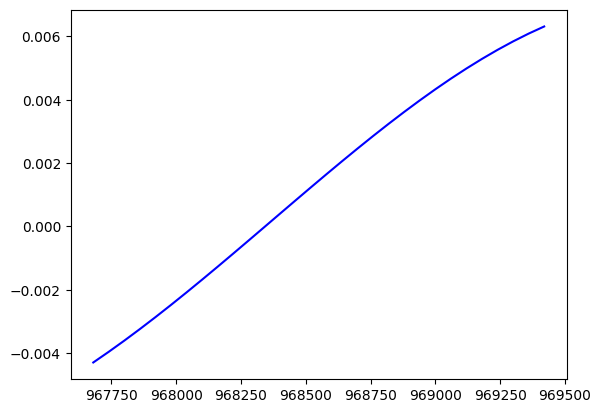

In [39]:
# inputs, labels = next(iter(multi_window_PINN.test))

# #destandardize labels
# labels = labels * train_std_PINN[8] + train_mean_PINN[8]

# #plot the labels of the first batch 
# plt.plot(inputs[0, :, 0].numpy()[:30], labels[0, :, 9].numpy(), 'b', label='x')


torch.Size([32, 300, 7])
torch.Size([32, 30, 7])
(3704, 30, 6)


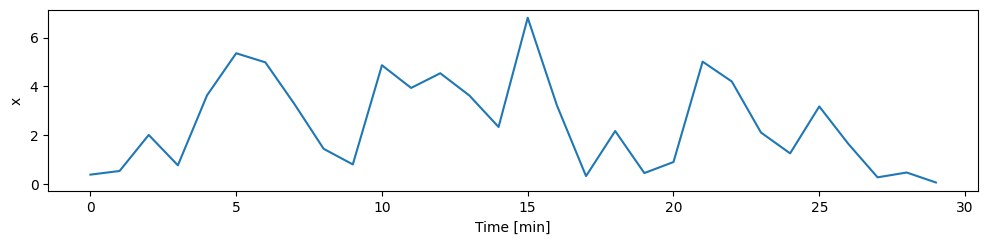

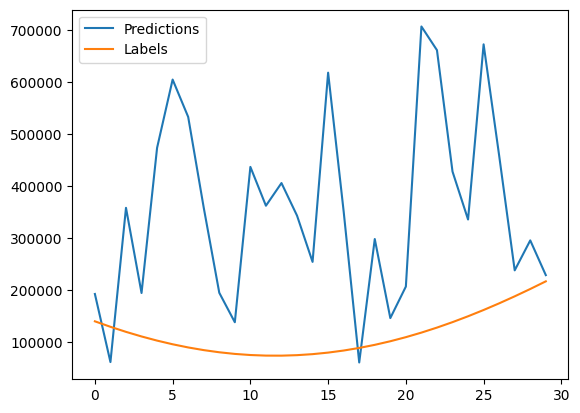

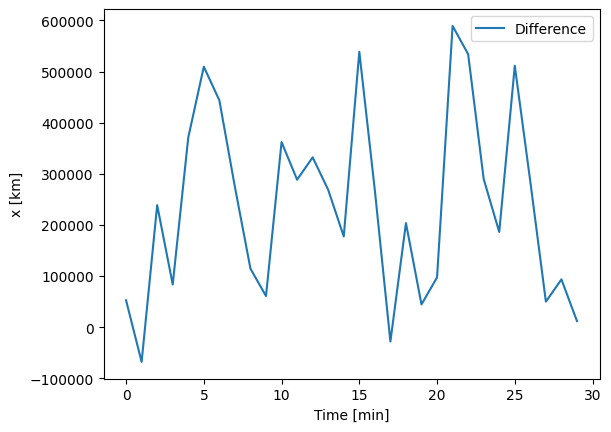

Mean Errors: 
X:  245839.52
Y:  7629.1562
Z:  847.56726
XDOT:  3026.563
YDOT:  5.701835
ZDOT:  0.8407413


In [112]:
def plot_diff_PINN(model, window, max_subplots=1, column=0):
    #bcs first column is time
    
    inputs, labels = next(iter(window.test))
        
    # labels = labels.numpy()
    predictions = model.predict(window.test)
    # predictions = predictions.numpy()

    inputs = inputs * train_std_Dense[column] + train_mean_Dense[column]
    labels = labels * train_std_Dense[column] + train_mean_Dense[column]
    predictions  = predictions * train_std_Dense[column] + train_mean_Dense[column]
    

    print(inputs.shape)
    print(labels.shape)
    print(predictions.shape)
    
    #make labels numpy
    labels = labels.numpy()

    plt.figure(figsize=(12, 8))
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)

        #fazer legendas diferentes para as velocidades
        plt.ylabel('x')
        plt.plot(np.abs((predictions[n, :, column] - labels[n, :, column+1])/labels[n, :, column+1]) ,label='Relative Error')
        plt.xlabel('Time [min]')
        plt.show()

        plt.plot(predictions[n, :, column] ,label='Predictions')
        plt.plot(labels[n, :, column+1] ,label='Labels')
        plt.legend()
        plt.show()

        plt.ylabel('x [km]')
        plt.plot((predictions[n, :, column] - labels[n, :, column+1]) ,label='Difference')
        plt.xlabel('Time [min]')
        plt.legend()
        plt.show()

        
plot_diff_PINN(modelPinnAux, multi_window_Dense, column=0) #x

#calculate the mean absolute error for each column
def calculateMeanErrors(model, window, max_subplots=1, column=0):
    #bcs first column is time

    inputs, labels = next(iter(window.test))
    predictions = model.predict(window.test)
    
    inputs = inputs * train_std_Dense[column] + train_mean_Dense[column]
    labels = labels * train_std_Dense[column] + train_mean_Dense[column]
    predictions  = predictions * train_std_Dense[column] + train_mean_Dense[column]
    
    labels = labels.numpy()
    
    meanError = np.mean(np.abs(predictions[0, :, column] - labels[0, :, column+1]))
    return meanError
    
    
meanErrorX = calculateMeanErrors(modelPinnAux, multi_window_Dense, column=0)
meanErrorY = calculateMeanErrors(modelPinnAux, multi_window_Dense, column=1)
meanErrorZ = calculateMeanErrors(modelPinnAux, multi_window_Dense, column=2)
meanErrorXDOT = calculateMeanErrors(modelPinnAux, multi_window_Dense, column=3)
meanErrorYDOT = calculateMeanErrors(modelPinnAux, multi_window_Dense, column=4)
meanErrorZDOT = calculateMeanErrors(modelPinnAux, multi_window_Dense, column=5)

print("Mean Errors: ")
print("X: ", meanErrorX)
print("Y: ", meanErrorY)
print("Z: ", meanErrorZ)
print("XDOT: ", meanErrorXDOT)
print("YDOT: ", meanErrorYDOT)
print("ZDOT: ", meanErrorZDOT)


# PINN (with initial state)

In [54]:
##########################################################
####### Trying to implement the github notebook (updated) ##########
##########################################################

class PhysicsInformedNN():
    def __init__(self, windowData, windowDataValidation):
        # data
        self.windowData = windowData
        self.windowDataValidation = windowDataValidation
        
        self.allLossesTraining = []
        self.allLossesValidation = []

        self.u_net_LossesTraining = []
        self.u_net_LossesValidation = []

        self.f_net_LossesTraining = []
        self.f_net_LossesValidation = []
        
        # deep neural networks
        num_features = 7
        num_outputs = 6
        self.dnn = tf.keras.Sequential([
            # Shape [batch, time, features] => [batch, features]
            # tf.keras.layers.Flatten(input_shape=(1440, num_features)),
            tf.keras.layers.Flatten(),
            
            tf.keras.layers.Dense(64, activation='LeakyReLU'),
            tf.keras.layers.Dense(64, activation='LeakyReLU'),
            tf.keras.layers.Dense(64, activation='LeakyReLU'),

            # Shape => [batch, out_steps*num_outputs]
            tf.keras.layers.Dense(OUT_STEPS*num_outputs, kernel_initializer=tf.keras.initializers.HeNormal()),
            # Shape => [batch, out_steps, num_outputs]
            tf.keras.layers.Reshape([OUT_STEPS, num_outputs])
        ])
        
        # optimizers: using the same settings
        self.optimizer = tf.optimizers.Adam()
        
        self.iter = 0
        
    def net_u(self, windowData):  
        #remove the time
        # # windowData = windowData[:, :, :-1]
        # time = windowData[:, :, 0:1]
        # initial_state = windowData[:, :, 1:]
        #tf.concat([time, initial_state], axis=-1)
        u = self.dnn(windowData)
        # u = self.dnn(windowData)
        return u
    
    def net_f(self, time, data):
        """ The TensorFlow version of calculating residual """

        #change data to variable
        time = tf.Variable(time, dtype=tf.float32)
        data = tf.Variable(data, dtype=tf.float32)


        x = data[:, :, 0]
        y = data[:, :, 1]
        z = data[:, :, 2]
        xdot = data[:, :, 3]
        ydot = data[:, :, 4]
        zdot = data[:, :, 5]

        def calculate_velocity(positions, t):
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(t)
                output = positions*t # Perform computation involving positions tensor and time tensor
            
            velocity = tape.gradient(output, t)
            return velocity

        x_dot = calculate_velocity(x, time)
        y_dot = calculate_velocity(y, time)
        z_dot = calculate_velocity(z, time)
        x_dot_dot = calculate_velocity(x_dot, time)
        y_dot_dot = calculate_velocity(y_dot, time)
        z_dot_dot = calculate_velocity(z_dot, time)

        
        #call SINDy to get the equations
        # model = getSindyEquations(data[:, :, 1:], data[:, :, 0])

        #create a tuple with the residual for each axis
        res_px = x_dot - data[:, :, 3]
        res_py = y_dot - data[:, :, 4]
        res_pz = z_dot - data[:, :, 5]


        # standardGravitationalParameter = 3.986004418 * 10**(5), using standardized  

        r = tf.sqrt(data[:, :, 0]**2 + data[:, :, 1]**2 + data[:, :, 2]**2)
        res_vx = x_dot_dot + standardGravitationalParameter * data[:, :, 0]/(r**3) 
        res_vy = y_dot_dot + standardGravitationalParameter * data[:, :, 1]/(r**3) 
        res_vz = z_dot_dot + standardGravitationalParameter * data[:, :, 2]/(r**3) 


        #concatenate the residuals into a single tensor
        res = tf.concat([res_px, res_py, res_pz, res_vx, res_vy, res_vz], axis=1)

        return res
    
    def loss_func(self, inputs, labels, isTraining = True):
        with tf.GradientTape() as tape:
            tape.watch(self.dnn.trainable_variables)
            
            #separate the time from the rest of the data
            timeAux = tf.Variable(inputs[:, :, 0])
            # initial_state = inputs[:, 0, 1:]
            # inputs = inputs[:, :, 1:]
            # u_pred = self.net_u(timeAux)

            u_pred = self.net_u(inputs)
            #limit timeAux for each batch to the shape of the output of the neural network
            timeAux = timeAux[:, 0:labels.shape[1]]

            f_pred = self.net_f(timeAux, u_pred)

            #remove the time from the labels
            labels = labels[:, :, 1:]
            loss_u = tf.reduce_mean(tf.square(labels - u_pred))
            loss_f = tf.reduce_mean(tf.square(f_pred))

            loss = loss_u + loss_f
        
        gradients = tape.gradient(loss, self.dnn.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.dnn.trainable_variables))
        
        self.iter += 1

        if isTraining:
            self.allLossesTraining.append(loss.numpy())
            self.u_net_LossesTraining.append(loss_u.numpy())
            self.f_net_LossesTraining.append(loss_f.numpy())
        else:
            self.allLossesValidation.append(loss.numpy())
            self.u_net_LossesValidation.append(loss_u.numpy())
            self.f_net_LossesValidation.append(loss_f.numpy())

        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.numpy(), loss_u.numpy(), loss_f.numpy())
            )
            
        return loss

    def validate(self):
        for example_inputs, example_labels in self.windowDataValidation:
            loss = self.loss_func(example_inputs, example_labels)
    
    def build(self, input_shape):
        self.dnn.build(input_shape)

    def train(self):
        self.dnn.trainable = True
        for _ in range(100):
            for n, (example_inputs, example_labels) in enumerate(self.windowData):
                loss = self.loss_func(example_inputs, example_labels)
            self.validate()

        self.dnn.trainable = False
                
    def predict(self, X):
        self.dnn.trainable = False
        u = self.net_u(X)
        #select the time from the input
        time = X[:, :, 0]
        #60 = output steps da window
        time = time[:, 0:OUT_STEPS]
        f = self.net_f(time, u)
        u = u.numpy()
        f = f.numpy()
        return u, f

    def plot_losses(self):
        
        # allLossesTraining
        # u_net_LossesTraining
        # f_net_LossesTraining
        # allLossesValidation
        # u_net_LossesValidation
        # f_net_LossesValidatiion

        plt.plot(self.allLossesTraining, label='Training Loss')
        plt.plot(self.allLossesValidation, label='Validation Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

modelTest = PhysicsInformedNN(multi_window_PINN.train, multi_window_PINN.val)
#build the model
#subtract one from the shape because the time is not an input
# modelTest.build(multi_window.example[0].shape)
modelTest.build((32, 1440, 7))
modelTest.train()

c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Iter 100, Loss: 6.75270e+07, Loss_u: 2.78975e+07, Loss_f: 3.96295e+07
Iter 200, Loss: 9.80336e+06, Loss_u: 4.03003e+06, Loss_f: 5.77333e+06
Iter 300, Loss: 1.52484e+06, Loss_u: 6.10849e+05, Loss_f: 9.13988e+05
Iter 400, Loss: 2.75891e+08, Loss_u: 1.19800e+08, Loss_f: 1.56092e+08
Iter 500, Loss: 1.00121e+07, Loss_u: 3.99271e+06, Loss_f: 6.01941e+06
Iter 600, Loss: 7.93109e+06, Loss_u: 3.16492e+06, Loss_f: 4.76618e+06
Iter 700, Loss: 5.99758e+06, Loss_u: 2.39542e+06, Loss_f: 3.60216e+06
Iter 800, Loss: 1.48222e+07, Loss_u: 5.93306e+06, Loss_f: 8.88910e+06
Iter 900, Loss: 2.52416e+06, Loss_u: 1.01037e+06, Loss_f: 1.51379e+06
Iter 1000, Loss: 1.72911e+06, Loss_u: 6.91259e+05, Loss_f: 1.03785e+06
Iter 1100, Loss: 1.31000e+06, Loss_u: 5.24625e+05, Loss_f: 7.85376e+05
Iter 1200, Loss: 1.30830e+07, Loss_u: 5.49912e+06, Loss_f: 7.58387e+06
Iter 1300, Loss: 5.88864e+05, Loss_u: 2.35234e+05, Loss_f: 3.53630e+05
Iter 1400, Loss: 5.96597e+05, Loss_u: 2.37051e+05, Loss_f: 3.59545e+05
Iter 1500, Loss

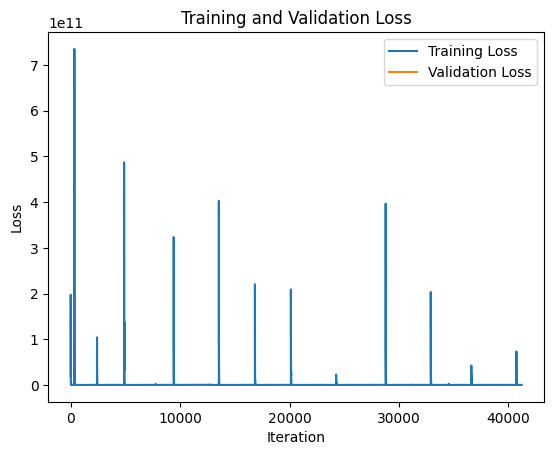

In [55]:
#plot losses
modelTest.plot_losses()

In [42]:
def plotAUX(window, model=None, max_subplots=1, column = 0):
  inputs, labels = next(iter(window.test))
  inputs = inputs.numpy()
  labels = labels.numpy()
  u_pred, f_pred = model.predict(inputs)
  predictions = tf.reshape(f_pred, (f_pred.shape[0], OUT_STEPS, 6))

  plt.figure(figsize=(12, 8))
  max_n = min(max_subplots, len(inputs))
  #destandardize data
  inputs = inputs * train_std_PINN[column] + train_mean_PINN[column]
  labels = labels * train_std_PINN[column] + train_mean_PINN[column]
  predictions  = predictions * train_std_PINN[column] + train_mean_PINN[column]
  
  print(inputs[0,:, 0].shape)
  print(inputs[0,:, 0])
  print(labels[0,:, 0].shape)
  print(labels[0,:, 0])
  
  for n in range(max_n):
        # plt.subplot(3, 1, n+1)
        #fazer legendas diferentes para as velocidades
        plt.ylabel('x [km]')
        plt.scatter(x= inputs[n,:, 0][:OUT_STEPS], y=labels[n, :, column], label='Labels', c='g', s=2)
        plt.scatter(x= inputs[n,:, 0][:OUT_STEPS], y=predictions[n, :, column], label='Predictions', c='r', s=2)
        # plt.plot(predictions[n, :, column] - labels[n, :, column] ,label='Difference')
        if n == 0:
            plt.legend()

  plt.xlabel('Time [min]')
WindowGenerator.plotAUX = plotAUX

In [271]:
#predict the results

#(32, 1440, 1)

# time_values = tf.concat([time for (time, _) in multi_window.test], axis=0)
# time_tensor = tf.expand_dims(time_values[:, :, 0], axis=-1)
# #remove the last dimension from time_tensor
# time_tensor = tf.squeeze(time_tensor, axis=-1)
# print(time_tensor.shape)

time_values = tf.concat([window[:, :, 0] for window, _ in multi_window_PINN.test], axis=0)
time_values = tf.expand_dims(time_values, axis=-1)
initial_states = tf.concat([window[:, 0, 1:] for window, _ in multi_window_PINN.test], axis=0)
initial_states_expanded = tf.expand_dims(initial_states, axis=1)
initial_states_broadcasted = tf.repeat(initial_states_expanded, repeats=1440, axis=1)

# Concatenate time values and initial states
input_tensor = tf.concat([time_values, initial_states_broadcasted], axis=-1)

u_pred, f_pred = modelTest.predict(input_tensor)
#reshape the results (xxx, OutputSteps, Variables)
f_pred_reshaped = tf.reshape(f_pred, (f_pred.shape[0], OUT_STEPS, 6))
u_pred_reshaped = tf.reshape(u_pred, (u_pred.shape[0], OUT_STEPS, 6))


#plot the results
#1st dimension, number of windows
#2nd dimension, number of out timesteps
#3rd dimension, number of variables
windowNr = 0
plt.plot(time_values[windowNr,:][:OUT_STEPS,:], f_pred_reshaped[windowNr, :,  0], label='x')
# plotAUX(multi_window_PINN, model=modelTest, max_subplots=3, column=1)
# multi_window_PINN.plot(modelTest.dnn)


################################################
################################################
#plot the true data
# destandardize the data multi_window
# print(list(multi_window.test)[0][0])
# testDataDestandardized = list(multi_window.test[0][1]) * train_std + train_mean

# for i in range(1, multi_window.test.element_spec[1].shape[-1]):
#     column_mean = train_mean[i - 1]
#     column_std = train_std[i - 1]
#     destandardized_test = multi_window.test.map(lambda inputs, labels: (inputs, labels * column_std + column_mean), num_parallel_calls=tf.data.AUTOTUNE)

# # print(list(destandardized_test))
# plt.plot(time_tensor[0,:], list(destandardized_test)[0][0][0, :, 1], label='x_dot')

# multi_window.plotAUX(modelTest, max_subplots=1, plot_col='x')


c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:256: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


InvalidArgumentError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [1154,60] vs. [1154,1440] [Op:Mul]

In [ ]:
print(multi_linear_model.summary())

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_49 (Lambda)          (32, 1, 6)                0         
                                                                 
 dense_101 (Dense)           (32, 1, 8640)             60480     
                                                                 
 reshape_49 (Reshape)        (32, 1440, 6)             0         
                                                                 
Total params: 60,480
Trainable params: 60,480
Non-trainable params: 0
_________________________________________________________________
None
